# The role of topology in decentralized learning

In [87]:
import numpy as np
import numpy.random as rd
import torch
import scipy.optimize as optim
import matplotlib.pyplot as plt
from topologies import *



In [86]:

%reload_ext autoreload
%autoreload 2


In [115]:
def DSGD_toypbm(lr, d, n, T, topologies, show):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2)

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    T: number of time steps
    topologies : list of topologies of the gossip matrix to try (symmetric, stochastic, size n*n)

    Prints at each iteration the state x obtained by worker i = 0
    """
    if show : # parameters to show the graph or not. If False the algorithm returns the norms X
        fig, ax = plt.subplots()
    final_results = []
    for topology in topologies: #The exponential matrix function works differently than others topologies       
        x0 = rd.normal(0,1, size = (d))
        X = np.block([[x0]]*n)
        norms = []
        #tau = int(math.log(n, 2))
        #effective_time = T #effective time considering the fact that time-varying exponential compyte d-time less communication
        #if topology == "Random exponential" or topology == "Time-varying exponential":
        #    effective_time = tau*T
        for t in range(T):
            W = scheme_for_string(topology, num_workers=n).w(t).numpy()
            for i in range(n):
                v = rd.normal(0,1, size = (d,1))
                X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:]) # Calculating the new value with the local gradient and the learning rate
            X = W.dot(X) #
            #if effective_time == tau*T:
                #if t%tau == 0:
                    #norms.append(np.mean(np.linalg.norm(X, axis = 1, ord = 2))) #We append to the list only 1 each tau time to have lists of the same size at the end
          
            norms.append(np.mean(np.linalg.norm(X, axis = 1, ord = 2))) # We calculate the norm of X for each workers, then average all norms. We store all the norms to plot
        if show : 
            ax.set_yscale('log')
            ax.plot(np.arange(0, T), norms, label = topology)
            ax.legend()
        final_results.append(norms[-1])
    if show: 
        plt.show()
    else:
        return final_results


In [93]:
import networkx as nx

tve = scheme_for_string("Time-varying exponential", num_workers=8).w(1).numpy()
print(scheme_for_string("Random exponential", num_workers=8).w(8).numpy())

#print(scheme_for_string("Random exponential", num_workers=8).w().numpy())

[[0.5 0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.5]
 [0.5 0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.5]]


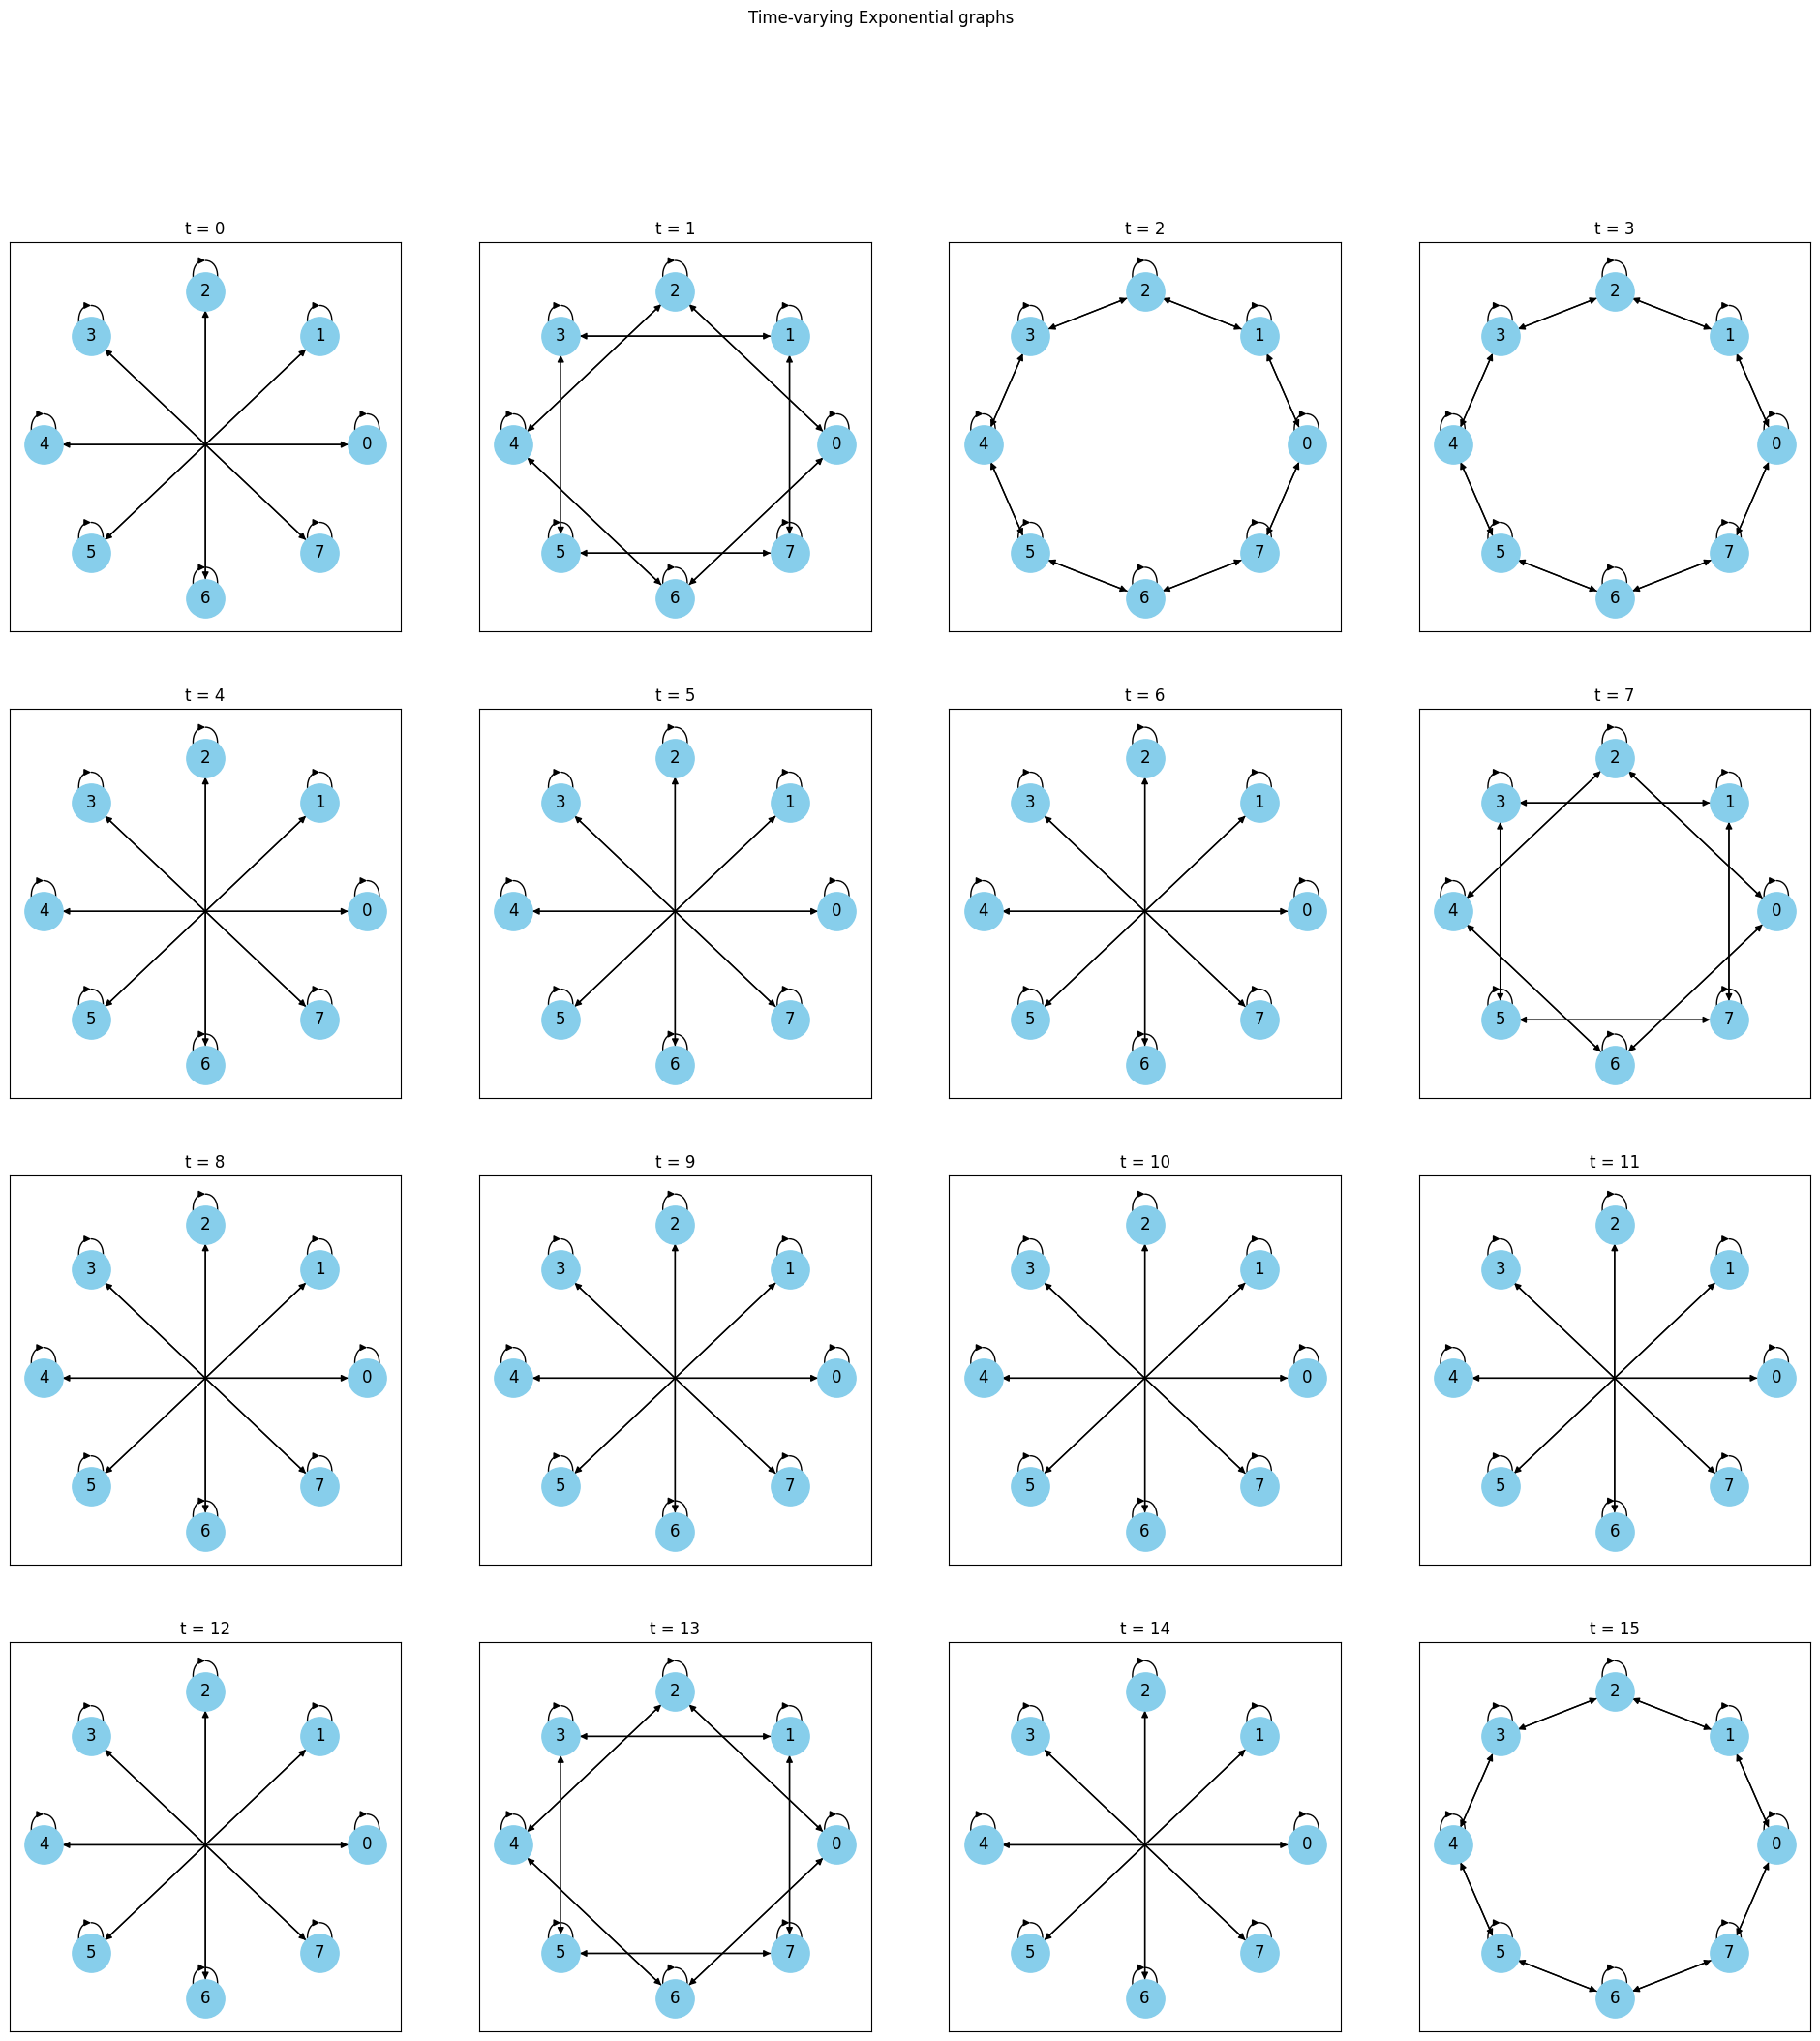

In [98]:
d = 8 #dimension
n = 32
T = 100



fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))
for t in range(16):
    G = nx.DiGraph()
    graph = nx.from_numpy_array(scheme_for_string("Random exponential", num_workers=8).w(t).numpy(), create_using = nx.DiGraph)
    pos = nx.circular_layout(graph)
    ax = axes[t//4, t%4]
    edges = graph.edges()
    nx.draw_networkx(graph, pos, ax=ax, node_color='skyblue', node_size=800, label = True, arrows = True)
    ax.set_title("t = {}".format(t))
fig.suptitle("Time-varying Exponential graphs")
plt.show()



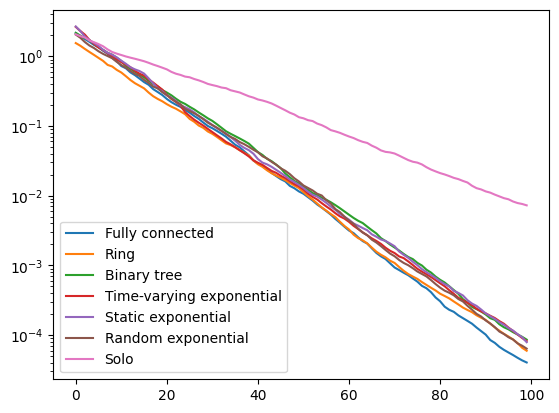

In [117]:
d = 8
n = 32
T = 100

topologies = [
        "Fully connected",
        "Ring",
        "Binary tree",
        "Time-varying exponential",
        "Static exponential",
        "Random exponential",
        "Solo"
    ]

DSGD_toypbm(0.1, d, n, T, topologies, True)


In [6]:
def list_learning_rates():
    '''
    Creating the list of learning_rates for the two next algorithms
    '''
    li = []
    for k in range(-2, 0):
        for j in range(1, 10):
            li.append(j*10**k)
    for k in range(9):
        li.append(1. + k/10)
    return li
print(list_learning_rates())

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]


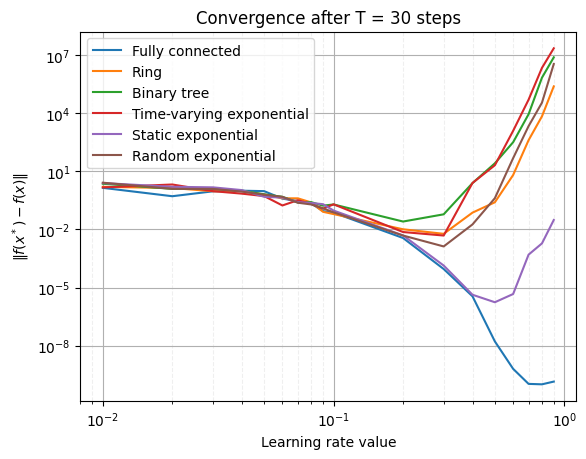

In [119]:
def learning_rate_dependency(d, n, T, topologies):
    """
    Plotting the value of the loss function after T steps for a given set of topologies, depending on the value of the learning rate

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """

    learning_rates = list_learning_rates()[:-9]
    matrix = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for lr, k in zip(learning_rates, range(len(learning_rates))):
        matrix[k,:] = np.array(DSGD_toypbm(lr, d, n, T, topologies, False)) # calculating the norm of x after n steps for a c
    for topology, j in zip(topologies, range(len(topologies))):
        ax.plot(learning_rates, matrix[:,j], label = topology)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    ax.set_ylabel(f'$\| f(x^*) - f(x) \| $')
    ax.set_xlabel('Learning rate value')
    ax.set_title('Convergence after T = {} steps'.format(T))
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()

learning_rate_dependency(d, n, 30, topologies[:-1])



/Users/valentin/anaconda3/envs/venv_ea/lib/python3.11/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/Users/valentin/anaconda3/envs/venv_ea/lib/python3.11/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/gq/lmr1rzls51b2k01h5jq8j9cm0000gn/T/ipykernel_20530/623211729.py:27: RuntimeWarning: overflow encountered in multiply
  X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
/var/folders/gq/lmr1rzls51b2k01h5jq8j9cm0000gn/T/ipykernel_20530/623211729.py:27: RuntimeWarning: overflow encountered in subtract
  X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])


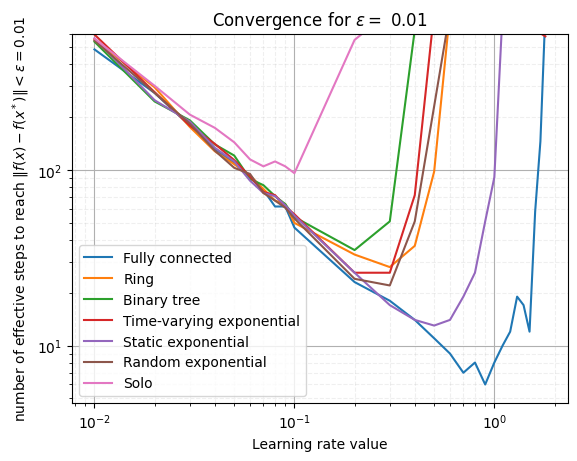

In [120]:
def DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2). This function returns
    the number of steps needed for the mean of the model in norm to be < epsilon

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """          
    x0 = rd.normal(0,1, size = (d))
    X = np.block([[x0]]*n)
    norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    T = 0
    #tau = int(math.log(n, 2))
    #if topology == "Random exponential" or topology == "Time-varying exponential":
    #    T_max = tau*T_max
    while (np.abs(norm) > epsilon and T < T_max):
        W = scheme_for_string(topology, num_workers=n).w(T).numpy()
        T += 1
        for i in range(n):
            v = rd.normal(0,1, size = (d,1))
            X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
        X = W.dot(X)
        norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    effective_time = T #effective time considering the fact that time-varying exponential compyte d-time less communication
    #if topology == "Random exponential" or topology == "Time-varying exponential":
    #       effective_time = T/tau
    return effective_time, norm





def learning_rate_dependency_number_of_steps(d, n, topologies, T_max, epsilon):
    '''
    Plotting the number of steps needed depending on the value of the learning rate and the topology to reach an error of the loss function < epsilon.
    
    Inputs :
    ----------
    d: dimension
    n: number of agents
    topologies: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    '''
    learning_rates = list_learning_rates()
    matrix_T = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for topology, j in zip(topologies, range(len(topologies))):
        for lr, k in zip(learning_rates, range(len(learning_rates))):
            matrix_T[k,j] = DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon)[0]  
        #if topology == "Random exponential" or topology == "Time-varying exponential":
        #    ax.plot(learning_rates[:-13], matrix_T[:-13,j], label = topology)
        #else :
        ax.plot(learning_rates, matrix_T[:,j], label = topology)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    ax.set_ylabel(f'number of effective steps to reach $\| f(x) - f(x^*)\| < \epsilon = ${epsilon}')
    ax.set_xlabel('Learning rate value')
    ax.set_ylim(top = 600)
    ax.set_title(f'Convergence for $\epsilon =$ {epsilon}')
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()

d = 8
n = 32
learning_rate_dependency_number_of_steps(d, n, topologies, 800, 0.01)

In [125]:
def nW(gamma, W):
    """
    Computes the effective number of neighbours of the gossip matrix W for the decay parameter gamma
    """
    lambdas = np.linalg.eigvals(W)
    denominator = np.mean(lambdas**2 / (1 - gamma*lambdas**2))
    return 1/(1-gamma) * 1/denominator

In [126]:
# The effective number of neighbours for the alone topology (W = I) should be 1 independently of gamma
nW(.5, )

1.0

In [123]:
def rate_toypbm(lr, zeta, W):
    """
    Computes the convergence rate of D-SGD in the toy-problem case

    Inputs:
    ----------------
    lr: learning rate of D-SGD
    zeta: noise level (= d + 2 in the case of the toy-problem in dimension d)
    W: gossip matrix used for D-SGD

    Outputs:
    ----------------
    r: convergence rate of D-SGD
    """
    f_tosolve = lambda r : r - (1 - (1 - lr)**2 - (zeta - 1) * lr**2 / nW((1-lr)**2 / (1-r), W))
    r = optim.fsolve(0, f_tosolve)
    return r

In [124]:
rate_toypbm(0.5, 6, np.eye(10))

TypeError: 'int' object is not callable